# Preprocessing

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

import json
import re
from bs4 import BeautifulSoup
import email
import urllib
import base64
import string
import quopri

import seaborn as sns
import sklearn.utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [2]:
## get paths of all spam and ham files
# path change might be needed if run on linux

# get list of all spam files (spamassassin)
spam_path_spamassassin = ".\\datasets\\spamassassin\\spam"
spam_files_spamassassin = [join(spam_path_spamassassin, f) for f in listdir(spam_path_spamassassin) if isfile(join(spam_path_spamassassin, f))]

# get list of all valid files (spamassassin)
ham_path_spamassassin = ".\\datasets\\spamassassin\\ham"
ham_files_spamassassin = [join(ham_path_spamassassin, f) for f in listdir(ham_path_spamassassin) if isfile(join(ham_path_spamassassin, f))]

# get list of all spam files (trec07p)
spam_path_trec07p = ".\\datasets\\trec07p\\spam"
spam_files_trec07p = [join(spam_path_trec07p, f) for f in listdir(spam_path_trec07p) if isfile(join(spam_path_trec07p, f))]

# get list of all valid files (trec07p)
ham_path_trec07p = ".\\datasets\\trec07p\\ham"
ham_files_trec07p = [join(ham_path_trec07p, f) for f in listdir(ham_path_trec07p) if isfile(join(ham_path_trec07p, f))]

In [3]:
# check lengths of files
len(spam_files_spamassassin)
len(ham_files_spamassassin)
len(spam_files_trec07p)
len(ham_files_trec07p)

25220

In [4]:
# combine all spam files, combine all ham files
all_spam = spam_files_spamassassin + spam_files_trec07p
all_ham = ham_files_spamassassin + ham_files_trec07p

In [15]:
all_spam[-50:]

['.\\datasets\\trec07p\\spam\\inmail.9939',
 '.\\datasets\\trec07p\\spam\\inmail.994',
 '.\\datasets\\trec07p\\spam\\inmail.9940',
 '.\\datasets\\trec07p\\spam\\inmail.9941',
 '.\\datasets\\trec07p\\spam\\inmail.9942',
 '.\\datasets\\trec07p\\spam\\inmail.9943',
 '.\\datasets\\trec07p\\spam\\inmail.9944',
 '.\\datasets\\trec07p\\spam\\inmail.9945',
 '.\\datasets\\trec07p\\spam\\inmail.9946',
 '.\\datasets\\trec07p\\spam\\inmail.9947',
 '.\\datasets\\trec07p\\spam\\inmail.9948',
 '.\\datasets\\trec07p\\spam\\inmail.9949',
 '.\\datasets\\trec07p\\spam\\inmail.995',
 '.\\datasets\\trec07p\\spam\\inmail.9950',
 '.\\datasets\\trec07p\\spam\\inmail.9951',
 '.\\datasets\\trec07p\\spam\\inmail.9952',
 '.\\datasets\\trec07p\\spam\\inmail.9954',
 '.\\datasets\\trec07p\\spam\\inmail.9956',
 '.\\datasets\\trec07p\\spam\\inmail.9957',
 '.\\datasets\\trec07p\\spam\\inmail.996',
 '.\\datasets\\trec07p\\spam\\inmail.9961',
 '.\\datasets\\trec07p\\spam\\inmail.9962',
 '.\\datasets\\trec07p\\spam\\inmai

In [5]:
print("Spam Mails:", len(all_spam))
print("Ham Mails:", len(all_ham))

Spam Mails: 52596
Ham Mails: 32171


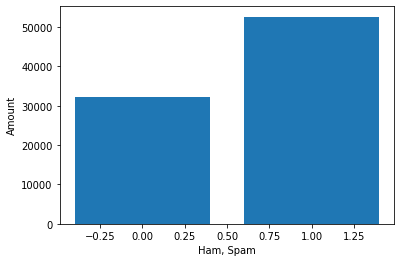

In [6]:
ywerte = [len(all_ham), len(all_spam)]
xwerte = [0, 1]
plt.bar(xwerte, ywerte)
plt.xlabel("Ham, Spam")
plt.ylabel("Amount")
plt.show()

In [9]:
def parse_email(email_raw):
    email_payload = email_raw.get_payload()
    
    email_body = ""

    if isinstance(email_payload, list):
        for part in email_payload:
            email_body += str(parse_email(part))

        return email_body
    else:
        if "Content-Type" in email_raw:
            if "text/html" in email_raw["Content-Type"].lower() or "text/plain" in email_raw["Content-Type"].lower(): # only parse content of type "text/html" and "text/plain"
                if "Content-Transfer-Encoding" in email_raw:
                    if email_raw["Content-Transfer-Encoding"].lower() == "base64": # check if its base64 encoded
                        try:
                            return str(base64.b64decode(email_payload))
                        except:       # if the decoding did not work
                            return "" # just return an empty string
                    elif email_raw["Content-Transfer-Encoding"].lower() == "quoted-printable":
                        try:
                            email_payload = ''.join(filter(lambda x: x in string.printable, email_payload))
                            return str(quopri.decodestring(email_payload))
                        except:       # if the decoding did not work
                            return "" # just return an empty string
                    else:
                        return email_payload
                else:
                    return email_payload
        elif email_raw.get_default_type() == "text/plain":
            # If the there is no "Content-Type" and the default type is "text/plain"
            return email_payload
        else:
            return ""

In [10]:
def parse_dataset(dataset, is_spam):
    rows = []
    parser = email.parser.BytesParser()
    re_email = re.compile("[\w.-]+@[\w.-]+.[\w.-]+", re.UNICODE)

    for mail in dataset:
        with open(mail, "rb") as f:

            email_raw = parser.parse(f)

            subject_mail = email_raw['subject']
            from_mail = email_raw['From']
            if from_mail != None:
                try:
                    from_mail = re_email.search(str(from_mail)).group()
                except AttributeError:
                    print("Could not parse email 'from' header")
                    from_mail = None
            
            try:
                email_payload = parse_email(email_raw)
            except Exception as e:
                print("[-] Unknown email parse error")
                
            if email_payload == None:
                print("Could not parse email body")
            
            if email_payload == None or len(email_payload) == 0:
                email_payload = "0"

            urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[-$_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', email_payload)
            domains = []
            if len(urls) == 0:
                urls = 0
            else:
                for url in urls:
                    try:
                        domains.append(re.sub(":\d+", "", urllib.parse.urlparse(url).netloc))
                    except:
                        print("Could not parse domain") 
                
            if len(domains) == 0:
                domains = 0

            if BeautifulSoup(email_payload.encode("utf-8"), "html.parser").find():
                cleantext = BeautifulSoup(email_payload, "html.parser").text
            else:
                cleantext = email_payload
                
            clean_data = cleantext
            clean_data.replace("\n", " ")

            rows.append([is_spam, cleantext, subject_mail, from_mail, urls, domains])
            
    return rows

In [12]:
model_spam_files = all_spam
model_ham_files = all_ham 

In [13]:
%%time
rows_spam = parse_dataset(model_spam_files, 1)
#rows_spam[2]

Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email body
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email body
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email body
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse email 'from' header
Could not parse ema

In [14]:
%%time
rows_ham = parse_dataset(model_ham_files, 0)
#rows_ham[2]

c:\users\konstantin\appdata\local\programs\python\python39\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
c:\users\konstantin\appdata\local\programs\python\python39\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://yenibiris.sendeyolla.com/medyadetay.aspx?&tid=3&cid=57&id=61365



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Could not parse email 'from' header
Wall time: 4min 28s


In [15]:
# create dataframe
rows_all = rows_spam + rows_ham
df = pd.DataFrame(rows_all, columns = ['spam', 'raw_data', 'subject', 'from', 'urls', 'domains'])

In [16]:
df

,spam,raw_data,subject,from,urls,domains
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie]
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc]
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo..."
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w..."
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w..."
...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org]
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch..."
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]"


In [10]:
# reshuffle dataframes (currently spam and ham are strictly separated)
df = sklearn.utils.shuffle(df)
# fix indices
df = df.reset_index(drop=True)
df

,spam,raw_data,subject,from,urls,domains
0,0,"On Tue, 17 Apr 2007, James W. MacDonald wrote:...",Re: [R] Greek symbols in xtable rows,Roger.Bivand@nhh.no,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch..."
1,1,"Mon, May 14, 2...","rent, Rent-A-List Special Reminder.",noloop@rent-a-list.com,"[http://imttrack.com, http://imttrack.com, htt...","[imttrack.com, imttrack.com, imttrack.com, www..."
2,1,Does Size Matter7\n----\n\n60% of WOMEN said t...,Is bunola in geneautry,ssjhoneyville@mpinet.net,[http://www.feruz.hk],[www.feruz.hk]
3,1,IRRESISTABLE FORMULA TO \nGET RICHAND STAY RIC...,Seven Figure Income Seeker,adcos2@walla.com,0,0
4,0,"If you use lme, you can fit a general correlat...",Re: [R] ANOVA non-sphericity test and correcti...,s.blomberg1@uq.edu.au,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch..."
...,...,...,...,...,...,...
49995,0,bitbitch@magnesium.net wrote:\n\n>>>Wishful th...,Re: A moment of silence for the First Amendmen...,owen@permafrost.net,0,0
49996,1,Does Size Matter7\n___\n\n60% of WOMEN said th...,He in adamsburg,lmobjack@careernow.info,[http://www.atgaros.com],[www.atgaros.com]
49997,1,"\n\n\n\nDear sirs,\nAegis Capital ...",Job: Just For You.,Saundra.Cook@computermail.net,"[http://joboffer-566115.aecapitall.hk, http://...","[joboffer-566115.aecapitall.hk, joboffer-56611..."
49998,1,Does Size Matter?\n-----\n\n60% of WOMEN said ...,My an elcho,jevarts@geld-ins-haus.de,[http://www.kliva.hk],[www.kliva.hk]


In [53]:
# get raw_data from column of index=3995
#df.iloc[3995].raw_data

c:\users\konstantin\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='spam', ylabel='count'>

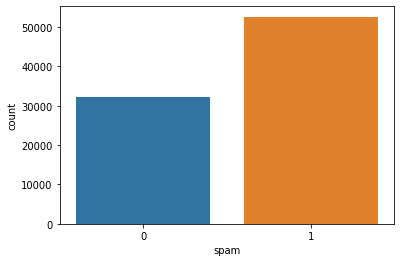

In [17]:
# show distribution of spam / ham emails
sns.countplot(df.spam)

In [18]:
# add missing punkt
#nltk.download('punkt')

# add columns for amount of chars / words
df["chars"] = df["raw_data"].apply(len)

In [19]:
df

,spam,raw_data,subject,from,urls,domains,chars
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie],3027
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc],1423
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo...",4349
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",781
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",636
...,...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org],840
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0,562
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch...",1178
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]",12536


In [20]:
def clean_text(text):
    # remove replies and forwards
    start_reply = re.search(r"\nOn .* wrote:", text)
    if start_reply != None:
        cleared_text = text[:start_reply.start()]
    else:
        cleared_text = text
    
    # remove \n or \r or \\n or \\r
    cleared_text = cleared_text.replace('\n', ' ').replace('\r', ' ').replace('\\n', ' ').replace('\\r', ' ')
    
    # remove URLs
    cleared_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[-$_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', cleared_text)
    
    # remove email addrs
    re_email = re.compile("[\w.-]+@[\w.-]+.[\w.-]+", re.UNICODE)
    cleared_text = re_email.sub(' ', cleared_text)
    
    # replace non-alpha chars with space
    cleared_text = re.sub('[^a-zA-Z]', ' ', cleared_text)
    
    # convert everything to lowercase
    cleared_text = cleared_text.lower()
    
    cleared_text = cleared_text.split()
    cleared_text = ' '.join(cleared_text)
    
    return cleared_text

In [21]:
%%time
# add new column for cleaned data (no urls, email addrs, only alpha, all lowercase)
df["data"] = df["raw_data"].apply(clean_text)

Wall time: 12.1 s


In [22]:
%%time
df["token_text"] = df.apply(lambda row: nltk.word_tokenize(str(row["data"])), axis=1)

Wall time: 43.3 s


In [23]:
df

,spam,raw_data,subject,from,urls,domains,chars,data,token_text
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie],3027,greetings you are receiving this letter becaus...,"[greetings, you, are, receiving, this, letter,..."
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc],1423,b save up to on life insurance why spend more ...,"[b, save, up, to, on, life, insurance, why, sp..."
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo...",4349,the need for safety is real in you might only ...,"[the, need, for, safety, is, real, in, you, mi..."
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",781,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p..."
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",636,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p..."
...,...,...,...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org],840,author metze date mon apr new revision websvn ...,"[author, metze, date, mon, apr, new, revision,..."
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0,562,on tom phoenix wrote on jm wrote the first gro...,"[on, tom, phoenix, wrote, on, jm, wrote, the, ..."
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch...",1178,charlie wrote hi this is charlie and i am tryi...,"[charlie, wrote, hi, this, is, charlie, and, i..."
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]",12536,author kseeger date mon apr new revision websv...,"[author, kseeger, date, mon, apr, new, revisio..."


In [24]:
df['tokens']  = df['token_text'].str.len()

In [25]:
df

,spam,raw_data,subject,from,urls,domains,chars,data,token_text,tokens
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie],3027,greetings you are receiving this letter becaus...,"[greetings, you, are, receiving, this, letter,...",510
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc],1423,b save up to on life insurance why spend more ...,"[b, save, up, to, on, life, insurance, why, sp...",173
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo...",4349,the need for safety is real in you might only ...,"[the, need, for, safety, is, real, in, you, mi...",533
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",781,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",95
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",636,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",82
...,...,...,...,...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org],840,author metze date mon apr new revision websvn ...,"[author, metze, date, mon, apr, new, revision,...",88
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0,562,on tom phoenix wrote on jm wrote the first gro...,"[on, tom, phoenix, wrote, on, jm, wrote, the, ...",89
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch...",1178,charlie wrote hi this is charlie and i am tryi...,"[charlie, wrote, hi, this, is, charlie, and, i...",151
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]",12536,author kseeger date mon apr new revision websv...,"[author, kseeger, date, mon, apr, new, revisio...",1531


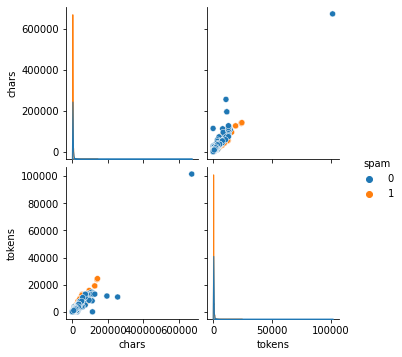

In [26]:
# pairplot
fg = sns.pairplot(data=df, hue="spam")
plt.show(fg)

In [117]:
# export dataframe to csv
#header = ['spam', 'data', 'subject', 'from', 'auth_error', 'urls', 'domains', 'No_of_Characters', 'No_of_Words']
#df.to_csv('output.csv', columns = header)

In [29]:
# nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

In [30]:
%%time
df["stop_text"] = df["token_text"].apply(remove_stopwords)

Wall time: 11.6 s


In [31]:
df

,spam,raw_data,subject,from,urls,domains,chars,data,token_text,tokens,stop_text
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie],3027,greetings you are receiving this letter becaus...,"[greetings, you, are, receiving, this, letter,...",510,"[greetings, receiving, letter, expressed, inte..."
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc],1423,b save up to on life insurance why spend more ...,"[b, save, up, to, on, life, insurance, why, sp...",173,"[b, save, life, insurance, spend, life, quote,..."
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo...",4349,the need for safety is real in you might only ...,"[the, need, for, safety, is, real, in, you, mi...",533,"[need, safety, real, might, get, one, chance, ..."
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",781,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",95,"[fight, risk, cancer, p, cfm, pk, slim, guaran..."
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",636,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",82,"[fight, risk, cancer, p, cfm, pk, slim, guaran..."
...,...,...,...,...,...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org],840,author metze date mon apr new revision websvn ...,"[author, metze, date, mon, apr, new, revision,...",88,"[author, metze, date, mon, apr, new, revision,..."
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0,562,on tom phoenix wrote on jm wrote the first gro...,"[on, tom, phoenix, wrote, on, jm, wrote, the, ...",89,"[tom, phoenix, wrote, jm, wrote, first, group,..."
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch...",1178,charlie wrote hi this is charlie and i am tryi...,"[charlie, wrote, hi, this, is, charlie, and, i...",151,"[charlie, wrote, hi, charlie, trying, embed, r..."
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]",12536,author kseeger date mon apr new revision websv...,"[author, kseeger, date, mon, apr, new, revisio...",1531,"[author, kseeger, date, mon, apr, new, revisio..."


In [32]:
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

In [33]:
%%time
df["clean_text"] = df["stop_text"].apply(lemmatize_word)

Wall time: 27.5 s


In [34]:
df

,spam,raw_data,subject,from,urls,domains,chars,data,token_text,tokens,stop_text,clean_text
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie],3027,greetings you are receiving this letter becaus...,"[greetings, you, are, receiving, this, letter,...",510,"[greetings, receiving, letter, expressed, inte...","[greet, receive, letter, express, interest, re..."
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc],1423,b save up to on life insurance why spend more ...,"[b, save, up, to, on, life, insurance, why, sp...",173,"[b, save, life, insurance, spend, life, quote,...","[b, save, life, insurance, spend, life, quote,..."
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo...",4349,the need for safety is real in you might only ...,"[the, need, for, safety, is, real, in, you, mi...",533,"[need, safety, real, might, get, one, chance, ...","[need, safety, real, might, get, one, chance, ..."
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",781,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",95,"[fight, risk, cancer, p, cfm, pk, slim, guaran...","[fight, risk, cancer, p, cfm, pk, slim, guaran..."
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",636,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",82,"[fight, risk, cancer, p, cfm, pk, slim, guaran...","[fight, risk, cancer, p, cfm, pk, slim, guaran..."
...,...,...,...,...,...,...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org],840,author metze date mon apr new revision websvn ...,"[author, metze, date, mon, apr, new, revision,...",88,"[author, metze, date, mon, apr, new, revision,...","[author, metze, date, mon, apr, new, revision,..."
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0,562,on tom phoenix wrote on jm wrote the first gro...,"[on, tom, phoenix, wrote, on, jm, wrote, the, ...",89,"[tom, phoenix, wrote, jm, wrote, first, group,...","[tom, phoenix, write, jm, write, first, group,..."
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch...",1178,charlie wrote hi this is charlie and i am tryi...,"[charlie, wrote, hi, this, is, charlie, and, i...",151,"[charlie, wrote, hi, charlie, trying, embed, r...","[charlie, write, hi, charlie, try, embed, r, a..."
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]",12536,author kseeger date mon apr new revision websv...,"[author, kseeger, date, mon, apr, new, revisio...",1531,"[author, kseeger, date, mon, apr, new, revisio...","[author, kseeger, date, mon, apr, new, revisio..."


In [35]:
## CREATE DB
import sqlite3

con = sqlite3.connect('bad_domains.db')
cur = con.cursor()

cur.execute("CREATE TABLE IF NOT EXISTS domains (domain TEXT PRIMARY KEY);")


with open("/resources/bad-domains.txt", "r") as f:
    for line in f.readlines():
        if len(line) == 0:
            continue
        line = line.replace('\n', '')
        try:        
            cur.execute("INSERT INTO domains VALUES ('%s')" % line)
        except:
            pass
    
con.commit()
con.close()

In [36]:
def check_domain(domains):
    
    if not domains:
        return 0
    
    con = sqlite3.connect('resources/bad_domains.db')
    cur = con.cursor()
    found = 0
    
    for domain in domains:
        cur.execute("SELECT * FROM domains WHERE domain = '%s'" % domain)
        if len(cur.fetchall()) > 0:
            found = 1
            break

    con.close()
    return found

In [37]:
%%time
df["bad_domain"] = df["domains"].apply(check_domain)

Wall time: 30.4 s


In [38]:
df["bad_domain"]

0        0
1        0
2        0
3        0
4        0
        ..
84762    0
84763    0
84764    0
84765    0
84766    0
Name: bad_domain, Length: 84767, dtype: int64

In [39]:
df.groupby(['spam', 'bad_domain']).size()

spam  bad_domain
0     0             31358
      1               813
1     0             52453
      1               143
dtype: int64

c:\users\konstantin\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bad_domain', ylabel='count'>

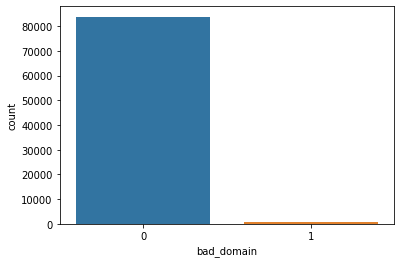

In [40]:
sns.countplot(df.bad_domain)

In [1]:
# there are more blacklisted urls in ham mails than in spam mails --> do not use this feature

In [41]:
def contains_urls(url_list):
    if url_list == 0:
        return 0
    else:
        return 1

In [42]:
df["contains_urls"] = df["domains"].apply(contains_urls)

In [43]:
df

,spam,raw_data,subject,from,urls,domains,chars,data,token_text,tokens,stop_text,clean_text,bad_domain,contains_urls
0,1,Greetings!\n\nYou are receiving this letter be...,[ILUG] STOP THE MLM INSANITY,startnow2002@hotmail.com,[http://www.linux.ie],[www.linux.ie],3027,greetings you are receiving this letter becaus...,"[greetings, you, are, receiving, this, letter,...",510,"[greetings, receiving, letter, expressed, inte...","[greet, receive, letter, express, interest, re...",0,1
1,1,b'\n\n\n\n\n\n \n \n \n \n \n \n...,Life Insurance - Why Pay More?,12a1mailbot1@web.de,[http://website.e365.cc],[website.e365.cc],1423,b save up to on life insurance why spend more ...,"[b, save, up, to, on, life, insurance, why, sp...",173,"[b, save, life, insurance, spend, life, quote,...","[b, save, life, insurance, spend, life, quote,...",0,1
2,1,\n\n\n\n\n\nThe Need For Safety Is Real In 200...,"Real Protection, Stun Guns! Free Shipping! Ti...",lmrn@mailexcite.com,"[http://www.geocities.com, http://www.geocitie...","[www.geocities.com, www.geocities.com, www.geo...",4349,the need for safety is real in you might only ...,"[the, need, for, safety, is, real, in, you, mi...",533,"[need, safety, real, might, get, one, chance, ...","[need, safety, real, might, get, one, chance, ...",0,1
3,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,taylor@s3.serveimage.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",781,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",95,"[fight, risk, cancer, p, cfm, pk, slim, guaran...","[fight, risk, cancer, p, cfm, pk, slim, guaran...",0,1
4,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,Guaranteed to lose 10-12 lbs in 30 days ...,sabrina@mx3.1premio.com,"[http://www.adclick.ws, http://www.adclick.ws,...","[www.adclick.ws, www.adclick.ws, www.adclick.w...",636,fight the risk of cancer p cfm o s pk slim dow...,"[fight, the, risk, of, cancer, p, cfm, o, s, p...",82,"[fight, risk, cancer, p, cfm, pk, slim, guaran...","[fight, risk, cancer, p, cfm, pk, slim, guaran...",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84762,0,Author: metze\nDate: 2007-04-16 07:41:12 +0000...,svn commit: samba r22248 - in\n\tbranches/SAMB...,metze@samba.org,[http://websvn.samba.org],[websvn.samba.org],840,author metze date mon apr new revision websvn ...,"[author, metze, date, mon, apr, new, revision,...",88,"[author, metze, date, mon, apr, new, revision,...","[author, metze, date, mon, apr, new, revision,...",0,1
84763,0,"On 4/9/07, Tom Phoenix wrote:\n>\n> On 4/9/07...",Re: OT: html checkbox question,jm5379@gmail.com,0,0,562,on tom phoenix wrote on jm wrote the first gro...,"[on, tom, phoenix, wrote, on, jm, wrote, the, ...",89,"[tom, phoenix, wrote, jm, wrote, first, group,...","[tom, phoenix, write, jm, write, first, group,...",0,0
84764,0,"\n\nCharlie wrote:\n> Hi, this is Charlie and ...",Re: [R] Question for install Rapache package.,ligges@statistik.uni-dortmund.de,"[https://stat.ethz.ch, http://www.R-project.or...","[stat.ethz.ch, www.R-project.org, stat.ethz.ch...",1178,charlie wrote hi this is charlie and i am tryi...,"[charlie, wrote, hi, this, is, charlie, and, i...",151,"[charlie, wrote, hi, charlie, trying, embed, r...","[charlie, write, hi, charlie, try, embed, r, a...",0,1
84765,0,Author: kseeger\nDate: 2007-04-16 07:47:27 +00...,svn commit: samba-docs r1098 - in trunk: manpa...,kseeger@samba.org,"[http://websvn.samba.org, http://www.samba.org...","[websvn.samba.org, www.samba.org, www.samba.org]",12536,author kseeger date mon apr new revision websv...,"[author, kseeger, date, mon, apr, new, revisio...",1531,"[author, kseeger, date, mon, apr, new, revisio...","[author, kseeger, date, mon, apr, new, revisio...",0,1


In [46]:
# Remove duplicates
df = df.drop_duplicates(subset="raw_data", keep="first")

# Remove emails with less then five words
print(f"All emails without dups: {len(df)}")
print(f"Emails with less then five words: {len(df[df['clean_text'].map(lambda d: len(d)) < 5])}")
df = df.drop(df[df['clean_text'].map(lambda d: len(d)) < 5].index)
print(f"Emails with at least 5 words: {len(df)}")

All emails without dups: 63570
Emails with less then five words: 869
Emails with at least 5 words: 62701


In [47]:
# dataframe without dups
joblib.dump(df, "exports/dataframe.sav")

['dataframe.sav']